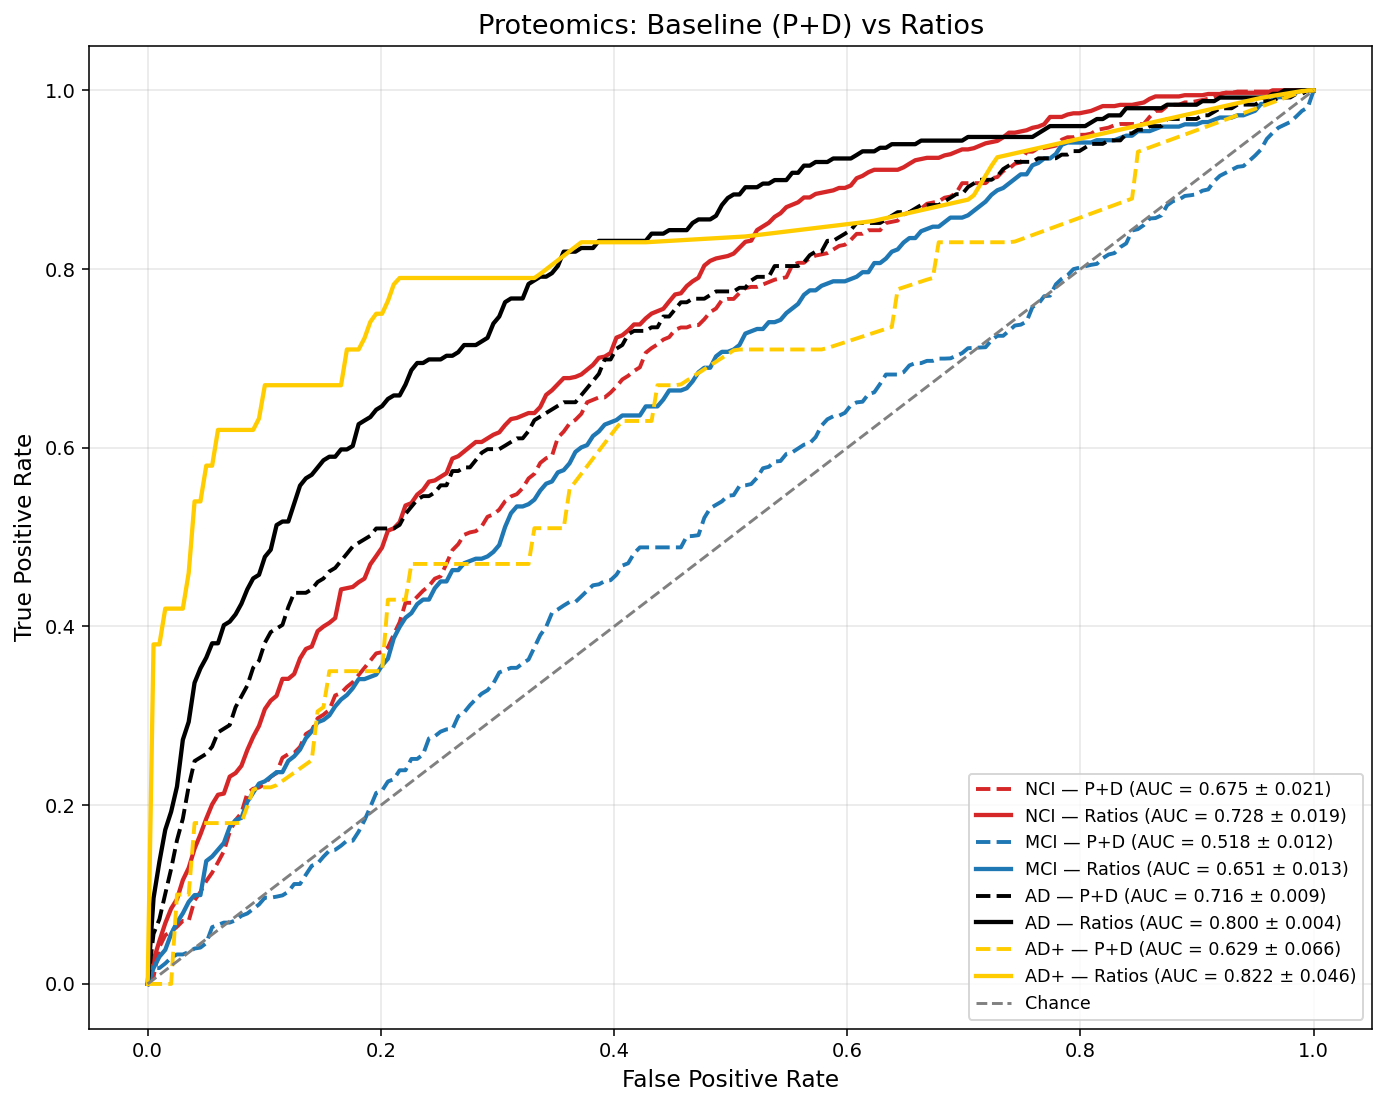

In [6]:
# === One-panel ROC: Baseline (P+D dashed) vs Ratios (solid), fixed class colors ===
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ----- Paths -----
baseline_folder = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)"
ratios_folder   = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe"

# ----- Classes (fixed colors) -----
classes = ["NCI", "MCI", "AD", "AD+"]
CLASS_COLOR = {
    "MCI": "#1f77b4",   # blue
    "NCI": "#d62728",   # red
    "AD":  "#000000",   # black
    "AD+": "#ffcc00",   # yellow
}

# Helpers
def safe_cls(c):
    return c.replace("+", "plus").replace(" ", "_").replace("/", "-")

def candidate_patterns(folder, cls):
    toks = [
        f"*_{cls}.csv",
        f"*_{cls.replace('+','plus')}.csv",
        f"*_{cls.replace(' ','_')}.csv",
        f"*_{safe_cls(cls)}.csv",
    ]
    seen, out = set(), []
    for t in toks:
        p = os.path.join(folder, f"seed{t}")
        if p not in seen:
            seen.add(p); out.append(p)
    return out

# Common grid
fpr_grid = np.linspace(0.0, 1.0, 200)

plt.figure(figsize=(10, 8), dpi=140)

def collect_model_stats(folder, cls):
    hits = []
    for pat in candidate_patterns(folder, cls):
        hits.extend(glob.glob(pat))
    hits = sorted(set(hits))
    if not hits:
        print(f"[warn] No files for class '{cls}' in {folder}")
        return None

    tprs_interp, aucs = [], []
    for path in hits:
        df = pd.read_csv(path)
        y_true  = df["y_true"].astype(int).values
        y_score = df["y_score"].astype(float).values
        fpr, tpr, _ = roc_curve(y_true, y_score)
        tpr_i = np.interp(fpr_grid, fpr, tpr)
        tpr_i[0] = 0.0
        tprs_interp.append(tpr_i)
        aucs.append(auc(fpr, tpr))

    tprs_interp = np.vstack(tprs_interp)
    mean_tpr = np.mean(tprs_interp, axis=0)
    auc_mean = float(np.mean(aucs))
    auc_std  = float(np.std(aucs, ddof=1)) if len(aucs) > 1 else 0.0
    n = len(aucs)
    auc_se = auc_std / np.sqrt(n) if n > 0 else 0.0
    return mean_tpr, auc_mean, auc_se, n

# Plot both models
for cls in classes:
    color = CLASS_COLOR[cls]

    # Baseline (dashed)
    b_stats = collect_model_stats(baseline_folder, cls)
    if b_stats is not None:
        b_mean_tpr, b_auc_mean, b_auc_se, b_n = b_stats
        plt.plot(
            fpr_grid, b_mean_tpr, linestyle="--", linewidth=2, color=color,
            label=f"{cls} — P+D (AUC = {b_auc_mean:.3f} ± {b_auc_se:.3f})"
        )

    # Ratios (solid)
    r_stats = collect_model_stats(ratios_folder, cls)
    if r_stats is not None:
        r_mean_tpr, r_auc_mean, r_auc_se, r_n = r_stats
        plt.plot(
            fpr_grid, r_mean_tpr, linestyle="-", linewidth=2.2, color=color,
            label=f"{cls} — Ratios (AUC = {r_auc_mean:.3f} ± {r_auc_se:.3f})"
        )

# Chance line (always grey dashed)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1.5, label="Chance")

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Proteomics: Baseline (P+D) vs Ratios", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right", fontsize=9, frameon=True)

out_dir = "/Users/adithyamadduri/Desktop/Projects/ml4h_project/Final_figures"
plot_path = os.path.join(out_dir, f"Proteomic_ROC_AUC_ratios.pdf")
plt.tight_layout()
plt.savefig(plot_path, dpi=300)
plt.show()

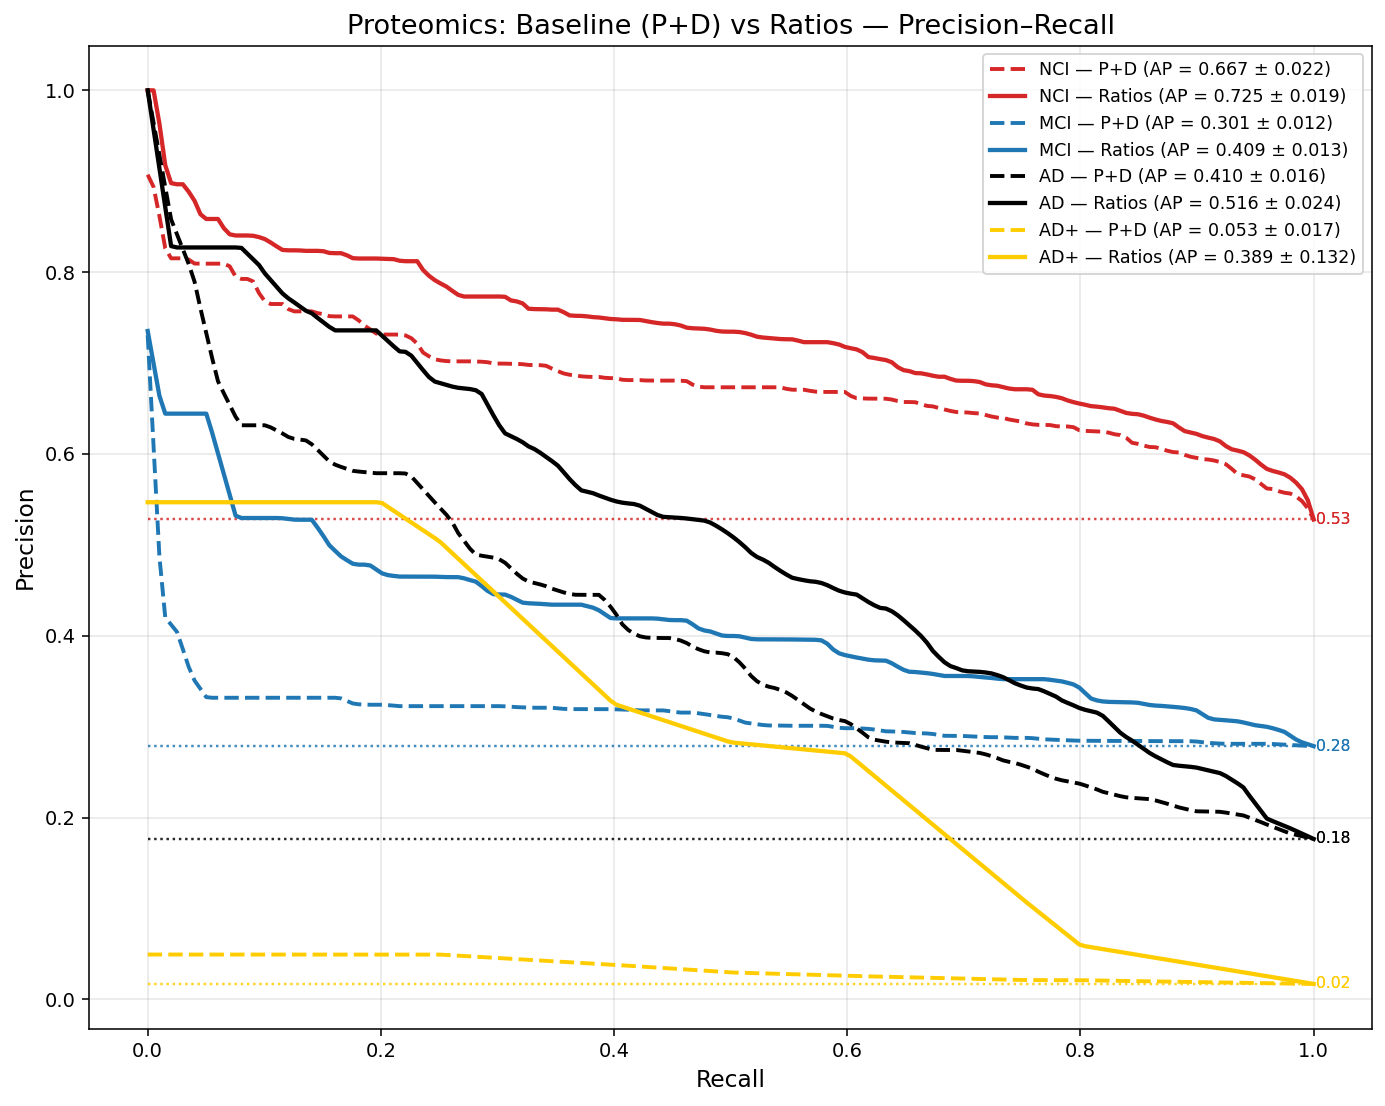

In [9]:
# === One-panel PR: Baseline (P+D dashed) vs Ratios (solid), fixed class colors ===
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# ----- Paths -----
baseline_folder = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)"
ratios_folder   = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe"

# ----- Classes (fixed colors) -----
classes = ["NCI", "MCI", "AD", "AD+"]
CLASS_COLOR = {
    "MCI": "#1f77b4",   # blue
    "NCI": "#d62728",   # red
    "AD":  "#000000",   # black
    "AD+": "#ffcc00",   # yellow
}

# Helpers
def safe_cls(c):
    return c.replace("+", "plus").replace(" ", "_").replace("/", "-")

def candidate_patterns(folder, cls):
    toks = [
        f"*_{cls}.csv",
        f"*_{cls.replace('+','plus')}.csv",
        f"*_{cls.replace(' ','_')}.csv",
        f"*_{safe_cls(cls)}.csv",
    ]
    seen, out = set(), []
    for t in toks:
        p = os.path.join(folder, f"seed{t}")
        if p not in seen:
            seen.add(p); out.append(p)
    return out

# Common recall grid
recall_grid = np.linspace(0.0, 1.0, 200)

def collect_pr_stats(folder, cls):
    """Return: (mean_precision_on_grid, mean_AP, se_AP, mean_prevalence, n_splits) or None"""
    hits = []
    for pat in candidate_patterns(folder, cls):
        hits.extend(glob.glob(pat))
    hits = sorted(set(hits))
    if not hits:
        print(f"[warn] No files for class '{cls}' in {folder}")
        return None

    prec_interp_list, aps, prevalences = [], [], []
    for path in hits:
        df = pd.read_csv(path)
        y_true  = df["y_true"].astype(int).values
        y_score = df["y_score"].astype(float).values

        # skip degenerate splits
        pos = y_true.sum()
        if pos == 0 or pos == len(y_true):
            continue

        precision, recall, _ = precision_recall_curve(y_true, y_score)

        # Deduplicate recall for interpolation
        uniq_idx = np.unique(recall, return_index=True)[1]
        r_u, p_u = recall[uniq_idx], np.maximum.accumulate( # keep precision non-increasing -> non-increasing reversed, so use cummax on reversed
            np.flip(np.maximum(0, np.minimum(1, precision[uniq_idx]))))[::-1]

        # Interpolate onto common recall grid
        p_i = np.interp(recall_grid, r_u, p_u, left=p_u[0], right=p_u[-1])
        prec_interp_list.append(p_i)

        aps.append(average_precision_score(y_true, y_score))
        prevalences.append(y_true.mean())

    if not prec_interp_list:
        print(f"[warn] No valid PR curves for class '{cls}' in {folder}")
        return None

    prec_interp = np.vstack(prec_interp_list)
    mean_prec = np.mean(prec_interp, axis=0)

    ap_mean = float(np.mean(aps))
    ap_std  = float(np.std(aps, ddof=1)) if len(aps) > 1 else 0.0
    n = len(aps)
    ap_se = ap_std / np.sqrt(n) if n > 0 else 0.0

    prev_mean = float(np.mean(prevalences)) if prevalences else 0.0

    return mean_prec, ap_mean, ap_se, prev_mean, n

plt.figure(figsize=(10, 8), dpi=140)

for cls in classes:
    color = CLASS_COLOR[cls]

    # Baseline (dashed)
    b_stats = collect_pr_stats(baseline_folder, cls)
    if b_stats is not None:
        b_mean_prec, b_ap_mean, b_ap_se, b_prev, b_n = b_stats
        plt.plot(
            recall_grid, b_mean_prec, linestyle="--", linewidth=2, color=color,
            label=f"{cls} — P+D (AP = {b_ap_mean:.3f} ± {b_ap_se:.3f})"
        )
        # Prevalence baseline (class-colored, dotted)
        plt.hlines(b_prev, 0, 1, colors=color, linestyles=":", linewidth=1.2, alpha=0.6)
        plt.text(1.002, b_prev, f"{b_prev:.2f}", color=color, va="center", fontsize=8)

    # Ratios (solid)
    r_stats = collect_pr_stats(ratios_folder, cls)
    if r_stats is not None:
        r_mean_prec, r_ap_mean, r_ap_se, r_prev, r_n = r_stats
        plt.plot(
            recall_grid, r_mean_prec, linestyle="-", linewidth=2.2, color=color,
            label=f"{cls} — Ratios (AP = {r_ap_mean:.3f} ± {r_ap_se:.3f})"
        )
        # If you prefer a single baseline, comment the P+D baseline above and keep this one.
        plt.hlines(r_prev, 0, 1, colors=color, linestyles=":", linewidth=1.2, alpha=0.6)
        plt.text(1.002, r_prev, f"{b_prev:.2f}", color=color, va="center", fontsize=8)

# Axes, title, legend
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Proteomics: Baseline (P+D) vs Ratios — Precision–Recall", fontsize=14)
plt.grid(True, alpha=0.3)

# Keep legend readable
plt.legend(loc="upper right", fontsize=9, frameon=True, ncol=1)

out_dir = "/Users/adithyamadduri/Desktop/Projects/ml4h_project/Final_figures"
plot_path = os.path.join(out_dir, f"Proteomic_PR_ratios.pdf")
plt.tight_layout()
plt.savefig(plot_path, dpi=300)
plt.show()

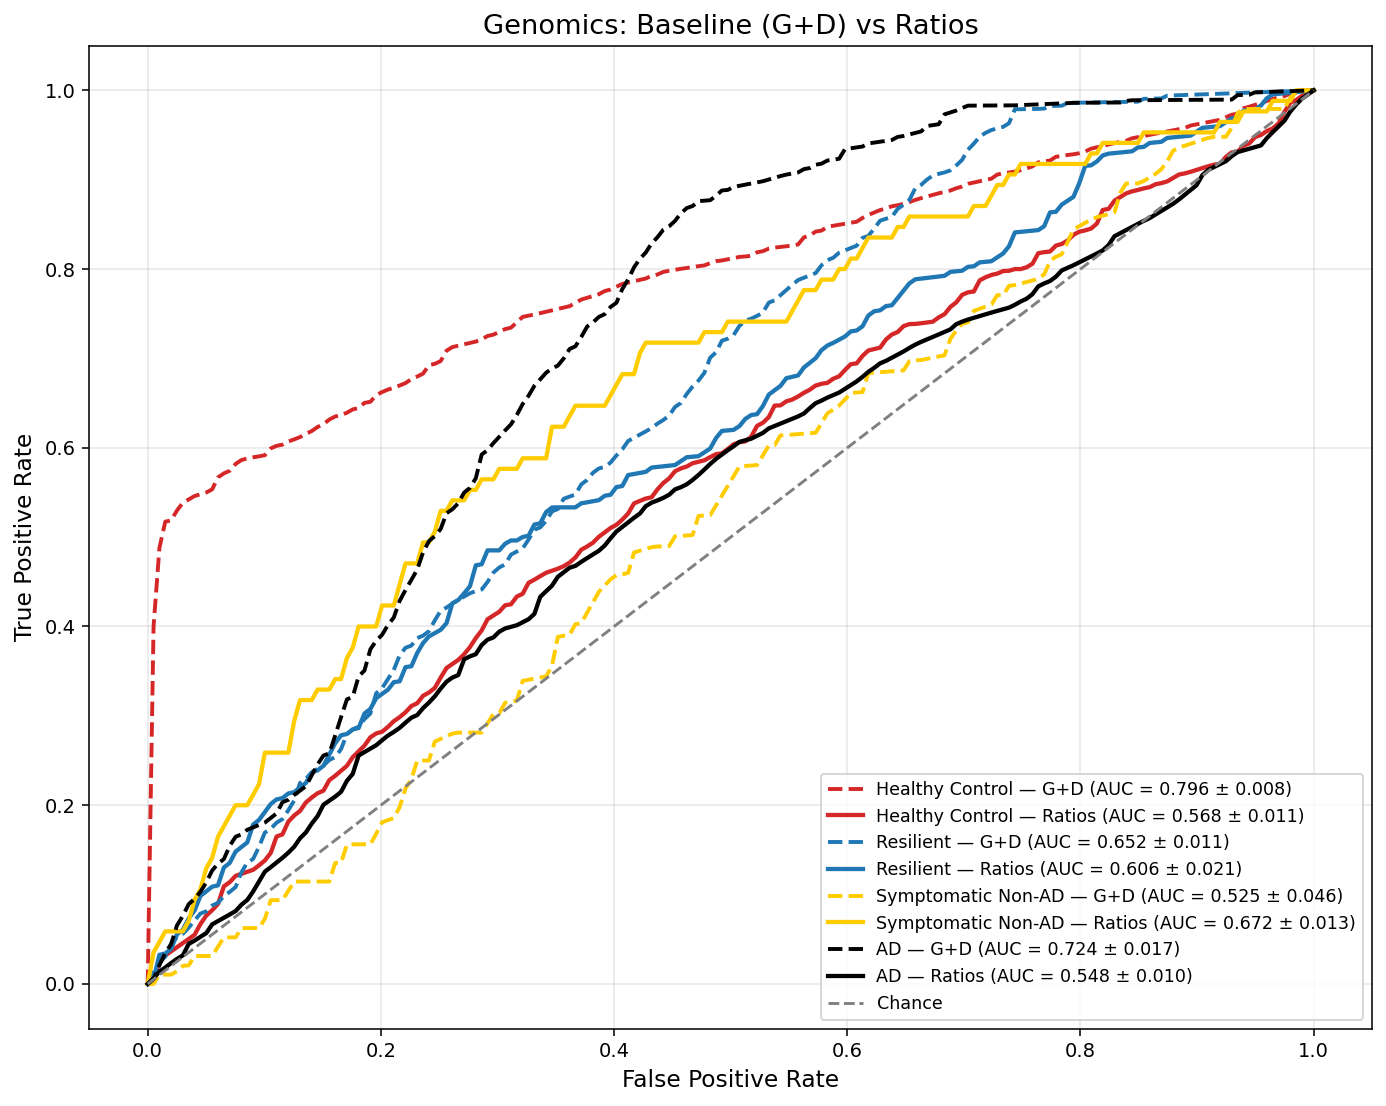

In [18]:
# === One-panel ROC: Baseline (P+D dashed) vs Ratios (solid), fixed class colors ===
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ----- Paths -----
baseline_folder = "/Users/adithyamadduri/Desktop/Projects/ml4h_project/LGBM(Genes+Demo)"
ratios_folder   = "/Users/adithyamadduri/Desktop/Projects/Genomics_LGBM(Genomics+Meta)_RATIOS_fixed_rfe"

# ----- Classes (fixed colors) -----
classes = ["Healthy Control", "Resilient", "Symptomatic Non-AD", "Typical AD"]
CLASS_COLOR = {
    "Resilient": "#1f77b4",   # blue
    "Healthy Control": "#d62728",   # red
    "Typical AD":  "#000000",   # black
    "Symptomatic Non-AD": "#ffcc00",   # yellow
}

DISPLAY_NAME = {
    "Typical AD": "AD"  # only change this one
}

# Helpers
def safe_cls(c):
    return c.replace("+", "plus").replace(" ", "_").replace("/", "-")

def candidate_patterns(folder, cls):
    toks = [
        f"*_{cls}.csv",
        f"*_{cls.replace('+','plus')}.csv",
        f"*_{cls.replace(' ','_')}.csv",
        f"*_{safe_cls(cls)}.csv",
    ]
    seen, out = set(), []
    for t in toks:
        p = os.path.join(folder, f"seed{t}")
        if p not in seen:
            seen.add(p); out.append(p)
    return out

# Common grid
fpr_grid = np.linspace(0.0, 1.0, 200)

plt.figure(figsize=(10, 8), dpi=140)

def collect_model_stats(folder, cls):
    hits = []
    for pat in candidate_patterns(folder, cls):
        hits.extend(glob.glob(pat))
    hits = sorted(set(hits))
    if not hits:
        print(f"[warn] No files for class '{cls}' in {folder}")
        return None

    tprs_interp, aucs = [], []
    for path in hits:
        df = pd.read_csv(path)
        y_true  = df["y_true"].astype(int).values
        y_score = df["y_score"].astype(float).values
        fpr, tpr, _ = roc_curve(y_true, y_score)
        tpr_i = np.interp(fpr_grid, fpr, tpr)
        tpr_i[0] = 0.0
        tprs_interp.append(tpr_i)
        aucs.append(auc(fpr, tpr))

    tprs_interp = np.vstack(tprs_interp)
    mean_tpr = np.mean(tprs_interp, axis=0)
    auc_mean = float(np.mean(aucs))
    auc_std  = float(np.std(aucs, ddof=1)) if len(aucs) > 1 else 0.0
    n = len(aucs)
    auc_se = auc_std / np.sqrt(n) if n > 0 else 0.0
    return mean_tpr, auc_mean, auc_se, n

# Plot both models
for cls in classes:
    color = CLASS_COLOR[cls]
    disp_cls = DISPLAY_NAME.get(cls, cls)

    # Baseline (dashed)
    b_stats = collect_model_stats(baseline_folder, cls)
    if b_stats is not None:
        b_mean_tpr, b_auc_mean, b_auc_se, b_n = b_stats
        plt.plot(
            fpr_grid, b_mean_tpr, linestyle="--", linewidth=2, color=color,
            label=f"{disp_cls} — G+D (AUC = {b_auc_mean:.3f} ± {b_auc_se:.3f})"
        )

    # Ratios (solid)
    r_stats = collect_model_stats(ratios_folder, cls)
    if r_stats is not None:
        r_mean_tpr, r_auc_mean, r_auc_se, r_n = r_stats
        plt.plot(
            fpr_grid, r_mean_tpr, linestyle="-", linewidth=2.2, color=color,
            label=f"{disp_cls} — Ratios (AUC = {r_auc_mean:.3f} ± {r_auc_se:.3f})"
        )

# Chance line (always grey dashed)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1.5, label="Chance")

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Genomics: Baseline (G+D) vs Ratios -", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right", fontsize=9, frameon=True)
out_dir = "/Users/adithyamadduri/Desktop/Projects/ml4h_project/Final_figures"
plot_path = os.path.join(out_dir, f"Genomic_AUC.pdf")
plt.tight_layout()
plt.savefig(plot_path, dpi=300)
plt.show()

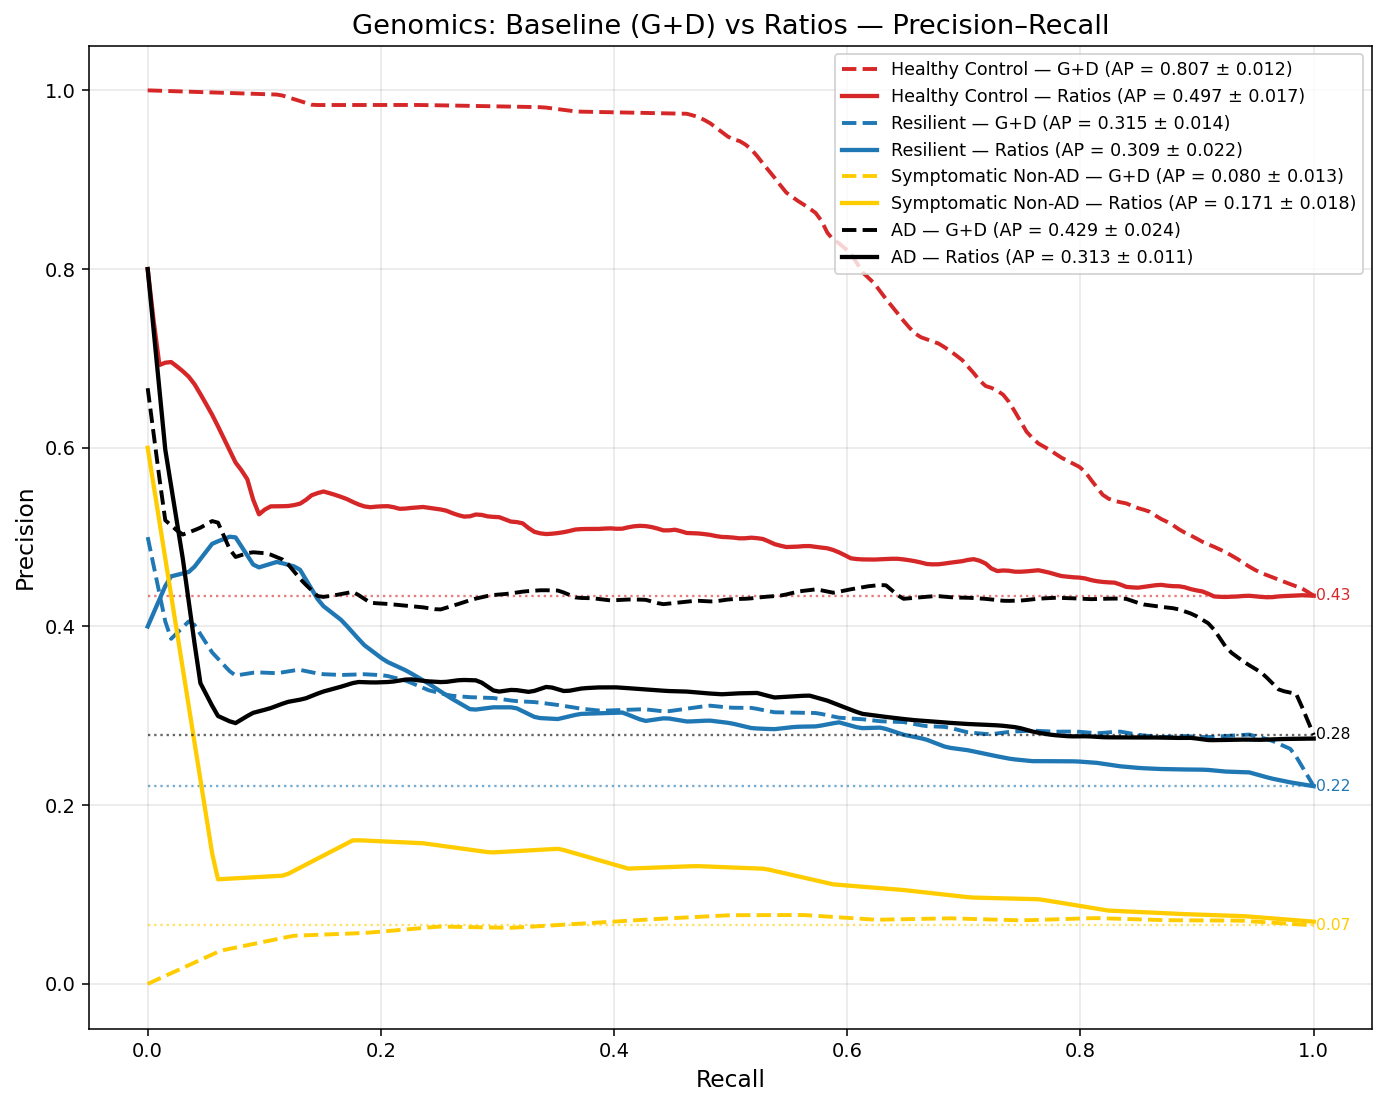

In [17]:
# === One-panel PR: Baseline (G+D dashed) vs Ratios (solid), fixed class colors ===
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# ----- Paths -----
baseline_folder = "/Users/adithyamadduri/Desktop/Projects/ml4h_project/LGBM(Genes+Demo)"
ratios_folder   = "/Users/adithyamadduri/Desktop/Projects/Genomics_LGBM(Genomics+Meta)_RATIOS_fixed_rfe"

# ----- Classes (fixed colors) -----
classes = ["Healthy Control", "Resilient", "Symptomatic Non-AD", "Typical AD"]
CLASS_COLOR = {
    "Resilient": "#1f77b4",          # blue
    "Healthy Control": "#d62728",    # red
    "Typical AD": "#000000",         # black
    "Symptomatic Non-AD": "#ffcc00", # yellow
}

# Display name tweaks (only AD shortened)
DISPLAY_NAME = {
    "Typical AD": "AD"
}

# Helpers
def safe_cls(c):
    return c.replace("+", "plus").replace(" ", "_").replace("/", "-")

def candidate_patterns(folder, cls):
    toks = [
        f"*_{cls}.csv",
        f"*_{cls.replace('+','plus')}.csv",
        f"*_{cls.replace(' ','_')}.csv",
        f"*_{safe_cls(cls)}.csv",
    ]
    seen, out = set(), []
    for t in toks:
        p = os.path.join(folder, f"seed{t}")
        if p not in seen:
            seen.add(p); out.append(p)
    return out

# Common recall grid
recall_grid = np.linspace(0.0, 1.0, 200)

def collect_pr_stats(folder, cls):
    """Return: (mean_precision_on_grid, mean_AP, se_AP, mean_prevalence, n_splits) or None"""
    hits = []
    for pat in candidate_patterns(folder, cls):
        hits.extend(glob.glob(pat))
    hits = sorted(set(hits))
    if not hits:
        print(f"[warn] No files for class '{cls}' in {folder}")
        return None

    prec_interp_list, aps, prevalences = [], [], []
    for path in hits:
        df = pd.read_csv(path)
        y_true  = df["y_true"].astype(int).values
        y_score = df["y_score"].astype(float).values

        # skip degenerate splits
        pos = y_true.sum()
        if pos == 0 or pos == len(y_true):
            continue

        precision, recall, _ = precision_recall_curve(y_true, y_score)

        # Deduplicate recall for interpolation
        uniq_idx = np.unique(recall, return_index=True)[1]
        r_u, p_u = recall[uniq_idx], precision[uniq_idx]

        # Interpolate precision onto common recall grid
        p_i = np.interp(recall_grid, r_u, p_u, left=p_u[0], right=p_u[-1])
        prec_interp_list.append(p_i)

        aps.append(average_precision_score(y_true, y_score))
        prevalences.append(y_true.mean())

    if not prec_interp_list:
        print(f"[warn] No valid PR curves for class '{cls}' in {folder}")
        return None

    mean_prec = np.mean(np.vstack(prec_interp_list), axis=0)
    ap_mean = float(np.mean(aps))
    ap_std  = float(np.std(aps, ddof=1)) if len(aps) > 1 else 0.0
    n = len(aps)
    ap_se = ap_std / np.sqrt(n) if n > 0 else 0.0
    prev_mean = float(np.mean(prevalences)) if prevalences else 0.0

    return mean_prec, ap_mean, ap_se, prev_mean, n

plt.figure(figsize=(10, 8), dpi=140)

for cls in classes:
    color = CLASS_COLOR[cls]
    disp = DISPLAY_NAME.get(cls, cls)

    # Baseline (dashed)
    b_stats = collect_pr_stats(baseline_folder, cls)
    if b_stats is not None:
        b_mean_prec, b_ap_mean, b_ap_se, b_prev, b_n = b_stats
        plt.plot(
            recall_grid, b_mean_prec, linestyle="--", linewidth=2, color=color,
            label=f"{disp} — G+D (AP = {b_ap_mean:.3f} ± {b_ap_se:.3f})"
        )
        # Class-colored prevalence baseline (dotted)
        plt.hlines(b_prev, 0, 1, colors=color, linestyles=":", linewidth=1.2, alpha=0.6)
        plt.text(1.002, b_prev, f"{b_prev:.2f}", color=color, va="center", fontsize=8)

    # Ratios (solid)
    r_stats = collect_pr_stats(ratios_folder, cls)
    if r_stats is not None:
        r_mean_prec, r_ap_mean, r_ap_se, r_prev, r_n = r_stats
        plt.plot(
            recall_grid, r_mean_prec, linestyle="-", linewidth=2.2, color=color,
            label=f"{disp} — Ratios (AP = {r_ap_mean:.3f} ± {r_ap_se:.3f})"
        )

# Axes, title, legend
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Genomics: Baseline (G+D) vs Ratios — Precision–Recall", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right", fontsize=9, frameon=True)
out_dir = "/Users/adithyamadduri/Desktop/Projects/ml4h_project/Final_figures"
plot_path = os.path.join(out_dir, f"Genomic_PR_ratios.pdf")
plt.tight_layout()
plt.savefig(plot_path, dpi=300)
plt.show()